# Práctica Calificada 02
## Predicción de tarifas de taxis

In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/MyDrive/AIProjects/PC2/Data/PracticaCalificada2-CC421/
%ls

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/.shortcut-targets-by-id/1ouCzEh7A4-s7GMx2btcWWTXkJxKP-98c/AIProjects/PC2/Data/PracticaCalificada2-CC421
data2.csv                      train_2014_and_2015_processed.csv
data2.csv.hdf5                 train_2014.csv
data2.csv.yaml                 train_2014_processed.csv
data.csv                       train_2015.csv
ht/                            train_2015_processed.csv
PracticaCalificada2-CC421.pdf  train_2.csv
rf_0                           train_2_processed.csv
rf_1                           train_2_processed_wo_gd.csv
rf_2                           train_3.csv
rf_3                           train_3_processed.csv
rf_4                           train_3_processed_wo_gd.csv
train_0.csv                    train_4.csv
train_0_processed.csv          train_4_processed.csv
train_0_processed_wo_gd.csv    train_4_processed_wo_gd.csv
train_1.csv                    train.cs

In [ ]:
import pandas as pd
import numpy as np

### Importar data total

In [ ]:
dtypes = {
      'key': 'object',
      'fare_amount': 'float64',
      'pickup_datetime': 'object',
      'pickup_longitude': 'float64', 
      'pickup_latitude': 'float64',
      'dropoff_longitude': 'float64',
      'dropoff_latitude': 'float64',
      'passenger_count': 'int64',
      
    
}
df = pd.read_csv("train.csv", dtype=dtypes)
df = df[['key', 'pickup_datetime', 'pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude', 'passenger_count', 'fare_amount']]
df.head()

,key,pickup_datetime,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,passenger_count,fare_amount
0,2009-06-15 17:26:21.0000001,2009-06-15 17:26:21 UTC,40.721319,-73.844311,40.712278,-73.841610,1,4.5
1,2010-01-05 16:52:16.0000002,2010-01-05 16:52:16 UTC,40.711303,-74.016048,40.782004,-73.979268,1,16.9
2,2011-08-18 00:35:00.00000049,2011-08-18 00:35:00 UTC,40.761270,-73.982738,40.750562,-73.991242,2,5.7
3,2012-04-21 04:30:42.0000001,2012-04-21 04:30:42 UTC,40.733143,-73.987130,40.758092,-73.991567,1,7.7
4,2010-03-09 07:51:00.000000135,2010-03-09 07:51:00 UTC,40.768008,-73.968095,40.783762,-73.956655,1,5.3


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55423856 entries, 0 to 55423855
Data columns (total 8 columns):
 #   Column             Dtype  
---  ------             -----  
 0   key                object 
 1   pickup_datetime    object 
 2   pickup_latitude    float64
 3   pickup_longitude   float64
 4   dropoff_latitude   float64
 5   dropoff_longitude  float64
 6   passenger_count    int64  
 7   fare_amount        float64
dtypes: float64(5), int64(1), object(2)
memory usage: 3.3+ GB


### Primera revisión de la data completa

#### Valores duplicados

In [ ]:
%time
duplicateRowsDF = df.loc[df.duplicated(['key'], keep=False), :]
duplicateRowsDF

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.25 µs


,key,pickup_datetime,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,passenger_count,fare_amount
3583097,2014-12-12 11:33:00.00000015,2014-12-12 11:33:00 UTC,40.773483,-73.955212,40.782178,-73.983742,1,10.0
55423855,2014-12-12 11:33:00.00000015,2014-12-12 11:33:00 UTC,40.797668,-73.969722,40.783313,-73.970885,1,7.5


In [ ]:
df['key'][55423855] =  '2014-12-12 11:33:00.00000016'

In [ ]:
# duplicateRowsDF = df.loc[df.duplicated(['key'], keep=False), :]
# duplicateRowsDF.shape[0]

#### Valores NaN

In [ ]:
valores_nan = df.isna().sum()
valores_nan

key                    0
pickup_datetime        0
pickup_latitude        0
pickup_longitude       0
dropoff_latitude     376
dropoff_longitude    376
passenger_count        0
fare_amount            0
dtype: int64

In [ ]:
df = df.dropna()

#### Coordenadas

Se analizará la data con el objetivo de eliminar las filas con coordenadas ubicadas en el océano.


In [ ]:
!pip install global-land-mask

In [ ]:
from global_land_mask import globe as gl

In [ ]:
df.shape

(55423480, 8)

In [ ]:
df = df[((df['pickup_latitude'].values > -90) & (df['pickup_latitude'].values < 90))]
df = df[(df['dropoff_latitude'].values > -90) & (df['dropoff_latitude'].values < 90) ]

df = df[(df['pickup_longitude'].values > -180) & (df['pickup_longitude'].values < 180)]
df = df[(df['dropoff_longitude'].values > -180) & (df['dropoff_longitude'].values < 180)]


In [ ]:
pla = df[['pickup_latitude']].to_numpy()
plon = df[['pickup_longitude']].to_numpy()
df = df.drop(df.loc[gl.is_ocean(pla,plon)].index)

dla = df[['dropoff_latitude']].to_numpy()
dlon = df[['dropoff_longitude']].to_numpy()
df = df.drop(df.loc[gl.is_ocean(dla,dlon)].index)

In [ ]:
df.shape

(54031179, 8)

#### Rango de valores

Ahora verificamos que los datos cumplan las restricciones de rango correspondientes.

In [ ]:
df.describe()

,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,passenger_count,fare_amount
count,5.403118e+07,5.403118e+07,5.403118e+07,5.403118e+07,5.403118e+07,5.403118e+07
mean,4.069348e+01,-7.390924e+01,4.069385e+01,-7.390909e+01,1.685326e+00,1.131566e+01
std,2.558227e+00,2.680539e+00,2.558269e+00,2.669993e+00,1.316547e+00,2.087019e+01
min,-7.783387e+01,-1.234080e+02,-7.435461e+01,-1.291153e+02,0.000000e+00,-3.000000e+02
25%,4.073667e+01,-7.399219e+01,4.073577e+01,-7.399148e+01,1.000000e+00,6.000000e+00
50%,4.075346e+01,-7.398205e+01,4.075398e+01,-7.398051e+01,1.000000e+00,8.500000e+00
75%,4.076762e+01,-7.396821e+01,4.076844e+01,-7.396521e+01,2.000000e+00,1.250000e+01
max,8.154545e+01,1.550187e+02,8.276667e+01,1.322415e+02,2.080000e+02,9.396336e+04


Observamos que el mínimo valor de la columna de tarifa (fare_amount) es -300. Necesitamos que los valores de la tarifa sean valores mayores o iguales a 0.

In [ ]:
df[df['fare_amount'] <= 0].count() /df.count()

key                  0.000062
pickup_datetime      0.000062
pickup_latitude      0.000062
pickup_longitude     0.000062
dropoff_latitude     0.000062
dropoff_longitude    0.000062
passenger_count      0.000062
fare_amount          0.000062
dtype: float64

In [ ]:
df = df[df['fare_amount'] >= 2.5]

Tambien existen valores atípicos muy alejados de la media, estos se pueden limitar mediante la desviación estandar. Eliminaremos los valores atípicos de la tarifa usando Z-score.

In [ ]:
mean = np.mean(df['fare_amount'])
std = np.std(df['fare_amount'])
df = df[(df['fare_amount']-mean)/std<3]

In [ ]:
df.shape

(53957580, 8)

También notamos valores atípicos en la cantidad de pasajeros, por ejemplo un viaje con 208 pasajeros. De acuerdo a las leyes de tránsito de Nueva York como máximo pueden haber 6 personas. Por lo tanto, las filas con cantidades de pasajeros mayores a 6 serán eliminadas.

In [ ]:
( (df[df['passenger_count'] > 6].count() + df[df['passenger_count'] < 1.0].count()) / df.count() )* 100

key                  0.352132
pickup_datetime      0.352132
pickup_latitude      0.352132
pickup_longitude     0.352132
dropoff_latitude     0.352132
dropoff_longitude    0.352132
passenger_count      0.352132
fare_amount          0.352132
dtype: float64

In [ ]:
df = df[df['passenger_count'] <= 6]

In [ ]:
df = df[df['passenger_count'] >= 1.0]

In [ ]:
df.describe()

,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,passenger_count,fare_amount
count,5.376758e+07,5.376758e+07,5.376758e+07,5.376758e+07,5.376758e+07,5.376758e+07
mean,4.069331e+01,-7.390905e+01,4.069368e+01,-7.390878e+01,1.691322e+00,1.120855e+01
std,2.562042e+00,2.684260e+00,2.562079e+00,2.673705e+00,1.307453e+00,9.106362e+00
min,-7.783387e+01,-1.234080e+02,-7.417884e+01,-1.291153e+02,1.000000e+00,2.500000e+00
25%,4.073667e+01,-7.399219e+01,4.073583e+01,-7.399146e+01,1.000000e+00,6.000000e+00
50%,4.075346e+01,-7.398206e+01,4.075400e+01,-7.398050e+01,1.000000e+00,8.500000e+00
75%,4.076762e+01,-7.396823e+01,4.076844e+01,-7.396520e+01,2.000000e+00,1.250000e+01
max,8.154545e+01,1.550187e+02,8.276667e+01,1.322415e+02,6.000000e+00,7.391000e+01


In [ ]:
df.to_csv('data2.csv', index = False, header=True)

## Con Vaex

In [ ]:
!pip install ipython==7.24.1

In [ ]:
!pip install vaex

In [ ]:
import vaex
import vaex.ml.sklearn
import pylab as plt

In [ ]:
df_original = vaex.from_csv('data2.csv', convert=True, chunk_size=5000000)

In [ ]:
df_original.head()

#,key,pickup_datetime,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,passenger_count,fare_amount
0,2009-06-15 17:26:21.0000001,2009-06-15 17:26:21 UTC,40.7213,-73.8443,40.7123,-73.8416,1,4.5
1,2010-01-05 16:52:16.0000002,2010-01-05 16:52:16 UTC,40.7113,-74.016,40.782,-73.9793,1,16.9
2,2011-08-18 00:35:00.00000049,2011-08-18 00:35:00 UTC,40.7613,-73.9827,40.7506,-73.9912,2,5.7
3,2012-04-21 04:30:42.0000001,2012-04-21 04:30:42 UTC,40.7331,-73.9871,40.7581,-73.9916,1,7.7
4,2010-03-09 07:51:00.000000135,2010-03-09 07:51:00 UTC,40.768,-73.9681,40.7838,-73.9567,1,5.3
5,2011-01-06 09:50:45.0000002,2011-01-06 09:50:45 UTC,40.7316,-74.001,40.7582,-73.9729,1,12.1
6,2012-11-20 20:35:00.0000001,2012-11-20 20:35:00 UTC,40.7517,-73.98,40.7648,-73.9738,1,7.5
7,2012-01-04 17:22:00.00000081,2012-01-04 17:22:00 UTC,40.7741,-73.9513,40.751,-73.9901,1,16.5
8,2012-12-03 13:10:00.000000125,2012-12-03 13:10:00 UTC,40.7267,-74.0065,40.7316,-73.9931,1,9
9,2009-09-02 01:11:00.00000083,2009-09-02 01:11:00 UTC,40.7339,-73.9807,40.7581,-73.9915,2,8.9


In [ ]:
df_original.info()

### Separacion de pickup_datetime en hora, day, semanas

Convertimos la variable categórica 'dia' a una variable indicadora

In [ ]:
df_original['day']=df_original['pickup_datetime'].apply(lambda x: pd.Timestamp(x).dayofweek)
df_original.head()

#,key,pickup_datetime,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,passenger_count,fare_amount,day
0,2009-06-15 17:26:21.0000001,2009-06-15 17:26:21 UTC,40.7213,-73.8443,40.7123,-73.8416,1,4.5,0
1,2010-01-05 16:52:16.0000002,2010-01-05 16:52:16 UTC,40.7113,-74.016,40.782,-73.9793,1,16.9,1
2,2011-08-18 00:35:00.00000049,2011-08-18 00:35:00 UTC,40.7613,-73.9827,40.7506,-73.9912,2,5.7,3
3,2012-04-21 04:30:42.0000001,2012-04-21 04:30:42 UTC,40.7331,-73.9871,40.7581,-73.9916,1,7.7,5
4,2010-03-09 07:51:00.000000135,2010-03-09 07:51:00 UTC,40.768,-73.9681,40.7838,-73.9567,1,5.3,1
5,2011-01-06 09:50:45.0000002,2011-01-06 09:50:45 UTC,40.7316,-74.001,40.7582,-73.9729,1,12.1,3
6,2012-11-20 20:35:00.0000001,2012-11-20 20:35:00 UTC,40.7517,-73.98,40.7648,-73.9738,1,7.5,1
7,2012-01-04 17:22:00.00000081,2012-01-04 17:22:00 UTC,40.7741,-73.9513,40.751,-73.9901,1,16.5,2
8,2012-12-03 13:10:00.000000125,2012-12-03 13:10:00 UTC,40.7267,-74.0065,40.7316,-73.9931,1,9,0
9,2009-09-02 01:11:00.00000083,2009-09-02 01:11:00 UTC,40.7339,-73.9807,40.7581,-73.9915,2,8.9,2


Obtenemos la hora de la misma manera de 'pickup_datetime'

In [ ]:
df_original['hour']=df_original['pickup_datetime'].apply(lambda x: pd.Timestamp(x).hour)
df_original.head()

#,key,pickup_datetime,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,passenger_count,fare_amount,day,hour
0,2009-06-15 17:26:21.0000001,2009-06-15 17:26:21 UTC,40.7213,-73.8443,40.7123,-73.8416,1,4.5,0,17
1,2010-01-05 16:52:16.0000002,2010-01-05 16:52:16 UTC,40.7113,-74.016,40.782,-73.9793,1,16.9,1,16
2,2011-08-18 00:35:00.00000049,2011-08-18 00:35:00 UTC,40.7613,-73.9827,40.7506,-73.9912,2,5.7,3,0
3,2012-04-21 04:30:42.0000001,2012-04-21 04:30:42 UTC,40.7331,-73.9871,40.7581,-73.9916,1,7.7,5,4
4,2010-03-09 07:51:00.000000135,2010-03-09 07:51:00 UTC,40.768,-73.9681,40.7838,-73.9567,1,5.3,1,7
5,2011-01-06 09:50:45.0000002,2011-01-06 09:50:45 UTC,40.7316,-74.001,40.7582,-73.9729,1,12.1,3,9
6,2012-11-20 20:35:00.0000001,2012-11-20 20:35:00 UTC,40.7517,-73.98,40.7648,-73.9738,1,7.5,1,20
7,2012-01-04 17:22:00.00000081,2012-01-04 17:22:00 UTC,40.7741,-73.9513,40.751,-73.9901,1,16.5,2,17
8,2012-12-03 13:10:00.000000125,2012-12-03 13:10:00 UTC,40.7267,-74.0065,40.7316,-73.9931,1,9,0,13
9,2009-09-02 01:11:00.00000083,2009-09-02 01:11:00 UTC,40.7339,-73.9807,40.7581,-73.9915,2,8.9,2,1


Pasamos la columna hora (números) a indicadora (mañana = 0, tarde =1y noche =2)


In [ ]:
df_original['hour']=df_original['hour'].apply(lambda x: 0 if x > 5 and x < 12 else 1 if x >=12 and x < 18 else 2)
df_original.head()  

#,key,pickup_datetime,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,passenger_count,fare_amount,day,hour
0,2009-06-15 17:26:21.0000001,2009-06-15 17:26:21 UTC,40.7213,-73.8443,40.7123,-73.8416,1,4.5,0,1
1,2010-01-05 16:52:16.0000002,2010-01-05 16:52:16 UTC,40.7113,-74.016,40.782,-73.9793,1,16.9,1,1
2,2011-08-18 00:35:00.00000049,2011-08-18 00:35:00 UTC,40.7613,-73.9827,40.7506,-73.9912,2,5.7,3,2
3,2012-04-21 04:30:42.0000001,2012-04-21 04:30:42 UTC,40.7331,-73.9871,40.7581,-73.9916,1,7.7,5,2
4,2010-03-09 07:51:00.000000135,2010-03-09 07:51:00 UTC,40.768,-73.9681,40.7838,-73.9567,1,5.3,1,0
5,2011-01-06 09:50:45.0000002,2011-01-06 09:50:45 UTC,40.7316,-74.001,40.7582,-73.9729,1,12.1,3,0
6,2012-11-20 20:35:00.0000001,2012-11-20 20:35:00 UTC,40.7517,-73.98,40.7648,-73.9738,1,7.5,1,2
7,2012-01-04 17:22:00.00000081,2012-01-04 17:22:00 UTC,40.7741,-73.9513,40.751,-73.9901,1,16.5,2,1
8,2012-12-03 13:10:00.000000125,2012-12-03 13:10:00 UTC,40.7267,-74.0065,40.7316,-73.9931,1,9,0,1
9,2009-09-02 01:11:00.00000083,2009-09-02 01:11:00 UTC,40.7339,-73.9807,40.7581,-73.9915,2,8.9,2,2


Añadimos el numero de la semana 

In [ ]:
df_original['week']=df_original['pickup_datetime'].apply(lambda x: pd.Timestamp(x).week)
df_original.head()

#,key,pickup_datetime,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,passenger_count,fare_amount,day,hour,week
0,2009-06-15 17:26:21.0000001,2009-06-15 17:26:21 UTC,40.7213,-73.8443,40.7123,-73.8416,1,4.5,0,1,25
1,2010-01-05 16:52:16.0000002,2010-01-05 16:52:16 UTC,40.7113,-74.016,40.782,-73.9793,1,16.9,1,1,1
2,2011-08-18 00:35:00.00000049,2011-08-18 00:35:00 UTC,40.7613,-73.9827,40.7506,-73.9912,2,5.7,3,2,33
3,2012-04-21 04:30:42.0000001,2012-04-21 04:30:42 UTC,40.7331,-73.9871,40.7581,-73.9916,1,7.7,5,2,16
4,2010-03-09 07:51:00.000000135,2010-03-09 07:51:00 UTC,40.768,-73.9681,40.7838,-73.9567,1,5.3,1,0,10
5,2011-01-06 09:50:45.0000002,2011-01-06 09:50:45 UTC,40.7316,-74.001,40.7582,-73.9729,1,12.1,3,0,1
6,2012-11-20 20:35:00.0000001,2012-11-20 20:35:00 UTC,40.7517,-73.98,40.7648,-73.9738,1,7.5,1,2,47
7,2012-01-04 17:22:00.00000081,2012-01-04 17:22:00 UTC,40.7741,-73.9513,40.751,-73.9901,1,16.5,2,1,1
8,2012-12-03 13:10:00.000000125,2012-12-03 13:10:00 UTC,40.7267,-74.0065,40.7316,-73.9931,1,9,0,1,49
9,2009-09-02 01:11:00.00000083,2009-09-02 01:11:00 UTC,40.7339,-73.9807,40.7581,-73.9915,2,8.9,2,2,36


Trayecto Nocturno

In [ ]:
df_original['trayecto_nocturno']=df_original['pickup_datetime'].apply(lambda x: pd.Timestamp(x).hour)


In [ ]:
df_original['trayecto_nocturno']=df_original['trayecto_nocturno'].apply(lambda x: 0 if x > 6 and x < 20 else 1)
df_original.head()  

#,key,pickup_datetime,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,passenger_count,fare_amount,day,hour,week,trayecto_nocturno
0,2009-06-15 17:26:21.0000001,2009-06-15 17:26:21 UTC,40.7213,-73.8443,40.7123,-73.8416,1,4.5,0,1,25,0
1,2010-01-05 16:52:16.0000002,2010-01-05 16:52:16 UTC,40.7113,-74.016,40.782,-73.9793,1,16.9,1,1,1,0
2,2011-08-18 00:35:00.00000049,2011-08-18 00:35:00 UTC,40.7613,-73.9827,40.7506,-73.9912,2,5.7,3,2,33,1
3,2012-04-21 04:30:42.0000001,2012-04-21 04:30:42 UTC,40.7331,-73.9871,40.7581,-73.9916,1,7.7,5,2,16,1
4,2010-03-09 07:51:00.000000135,2010-03-09 07:51:00 UTC,40.768,-73.9681,40.7838,-73.9567,1,5.3,1,0,10,0
5,2011-01-06 09:50:45.0000002,2011-01-06 09:50:45 UTC,40.7316,-74.001,40.7582,-73.9729,1,12.1,3,0,1,0
6,2012-11-20 20:35:00.0000001,2012-11-20 20:35:00 UTC,40.7517,-73.98,40.7648,-73.9738,1,7.5,1,2,47,1
7,2012-01-04 17:22:00.00000081,2012-01-04 17:22:00 UTC,40.7741,-73.9513,40.751,-73.9901,1,16.5,2,1,1,0
8,2012-12-03 13:10:00.000000125,2012-12-03 13:10:00 UTC,40.7267,-74.0065,40.7316,-73.9931,1,9,0,1,49,0
9,2009-09-02 01:11:00.00000083,2009-09-02 01:11:00 UTC,40.7339,-73.9807,40.7581,-73.9915,2,8.9,2,2,36,1


Hora punta

In [ ]:
df_original['hora_punta']=df_original['pickup_datetime'].apply(lambda x: pd.Timestamp(x).hour)
df_original['hora_punta']=df_original['hora_punta'].apply(lambda x: 1 if x >=16 and x <= 20 else 0)
df_original.head()

#,key,pickup_datetime,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,passenger_count,fare_amount,day,hour,week,trayecto_nocturno,hora_punta
0,2009-06-15 17:26:21.0000001,2009-06-15 17:26:21 UTC,40.7213,-73.8443,40.7123,-73.8416,1,4.5,0,1,25,0,1
1,2010-01-05 16:52:16.0000002,2010-01-05 16:52:16 UTC,40.7113,-74.016,40.782,-73.9793,1,16.9,1,1,1,0,1
2,2011-08-18 00:35:00.00000049,2011-08-18 00:35:00 UTC,40.7613,-73.9827,40.7506,-73.9912,2,5.7,3,2,33,1,0
3,2012-04-21 04:30:42.0000001,2012-04-21 04:30:42 UTC,40.7331,-73.9871,40.7581,-73.9916,1,7.7,5,2,16,1,0
4,2010-03-09 07:51:00.000000135,2010-03-09 07:51:00 UTC,40.768,-73.9681,40.7838,-73.9567,1,5.3,1,0,10,0,0
5,2011-01-06 09:50:45.0000002,2011-01-06 09:50:45 UTC,40.7316,-74.001,40.7582,-73.9729,1,12.1,3,0,1,0,0
6,2012-11-20 20:35:00.0000001,2012-11-20 20:35:00 UTC,40.7517,-73.98,40.7648,-73.9738,1,7.5,1,2,47,1,1
7,2012-01-04 17:22:00.00000081,2012-01-04 17:22:00 UTC,40.7741,-73.9513,40.751,-73.9901,1,16.5,2,1,1,0,1
8,2012-12-03 13:10:00.000000125,2012-12-03 13:10:00 UTC,40.7267,-74.0065,40.7316,-73.9931,1,9,0,1,49,0,0
9,2009-09-02 01:11:00.00000083,2009-09-02 01:11:00 UTC,40.7339,-73.9807,40.7581,-73.9915,2,8.9,2,2,36,1,0


Año

In [ ]:
df_original['year']=df_original['pickup_datetime'].apply(lambda x: pd.Timestamp(x).year)
df_original.head()  

#,key,pickup_datetime,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,passenger_count,fare_amount,day,hour,week,trayecto_nocturno,hora_punta,year
0,2009-06-15 17:26:21.0000001,2009-06-15 17:26:21 UTC,40.7213,-73.8443,40.7123,-73.8416,1,4.5,0,1,25,0,1,2009
1,2010-01-05 16:52:16.0000002,2010-01-05 16:52:16 UTC,40.7113,-74.016,40.782,-73.9793,1,16.9,1,1,1,0,1,2010
2,2011-08-18 00:35:00.00000049,2011-08-18 00:35:00 UTC,40.7613,-73.9827,40.7506,-73.9912,2,5.7,3,2,33,1,0,2011
3,2012-04-21 04:30:42.0000001,2012-04-21 04:30:42 UTC,40.7331,-73.9871,40.7581,-73.9916,1,7.7,5,2,16,1,0,2012
4,2010-03-09 07:51:00.000000135,2010-03-09 07:51:00 UTC,40.768,-73.9681,40.7838,-73.9567,1,5.3,1,0,10,0,0,2010
5,2011-01-06 09:50:45.0000002,2011-01-06 09:50:45 UTC,40.7316,-74.001,40.7582,-73.9729,1,12.1,3,0,1,0,0,2011
6,2012-11-20 20:35:00.0000001,2012-11-20 20:35:00 UTC,40.7517,-73.98,40.7648,-73.9738,1,7.5,1,2,47,1,1,2012
7,2012-01-04 17:22:00.00000081,2012-01-04 17:22:00 UTC,40.7741,-73.9513,40.751,-73.9901,1,16.5,2,1,1,0,1,2012
8,2012-12-03 13:10:00.000000125,2012-12-03 13:10:00 UTC,40.7267,-74.0065,40.7316,-73.9931,1,9,0,1,49,0,0,2012
9,2009-09-02 01:11:00.00000083,2009-09-02 01:11:00 UTC,40.7339,-73.9807,40.7581,-73.9915,2,8.9,2,2,36,1,0,2009


### Verificar si el punto de llegada o punto de partida se encuentra cerca al aeropuerto

In [ ]:
def area_aeropuerto(drop_latitud, drop_longitud, pickup_latitud, pickup_longitud):
  value = 0

  latJFK , longJFK = (40.64607900467552, -73.78682189872009)
  rLatJFK , rLongJFK = (0.00020442868149724404, 7.06525997713248e-05)

  latLaGuardia , longLaGuardia = (40.77721540400873, -73.87389625196624 )
  rLaLaGuardia , rLongLaGuardia = (7.901000033306362e-05, 5.571223534203251e-08)

  latNewark, longNewark = (40.69124374918179, -74.1782152271882)
  rLatNewark, rLongNewark = (4.851167653135607e-05, 0.00017069473805533363)

  dLatKFK , dLongJFK = ((40.64607900467552 - drop_latitud )**2, (-73.78682189872009 - drop_longitud)**2)
  dLatLaGuardia, dLongLaGuardia = ((40.77721540400873 - drop_latitud )**2, (-73.87389625196624 - drop_longitud)**2)
  dLatNewark, dLongNewark = ((40.69124374918179 - drop_latitud )**2, (-74.1782152271882 - drop_longitud)**2)

  pLatKFK , pLongJFK = ((40.64607900467552 - pickup_latitud )**2, (-73.78682189872009 - pickup_longitud)**2)
  pLatLaGuardia, pLongLaGuardia = ((40.77721540400873 - pickup_latitud )**2, (-73.87389625196624 - pickup_longitud)**2)
  pLatNewark, pLongNewark = ((40.69124374918179 - pickup_latitud )**2, (-74.1782152271882 - pickup_longitud)**2)

  if (dLatKFK <= rLatJFK  and dLongJFK <= rLongJFK) or (pLatKFK <= rLatJFK and pLongJFK <= rLongJFK):
    value = 1
  if (dLatLaGuardia <= rLaLaGuardia  and dLongLaGuardia <= rLongLaGuardia) or (pLatLaGuardia <= rLaLaGuardia  and pLongLaGuardia <= rLongLaGuardia):
    value = 1
  if (dLatNewark <= rLatNewark  and dLongNewark <= rLongNewark) or (pLatNewark <= rLatNewark  and pLongNewark <= rLongNewark):
    value = 1
  return value

In [ ]:
df_original['aeropuerto'] = df_original.apply(area_aeropuerto, [df_original.dropoff_latitude, df_original.dropoff_longitude, df_original.pickup_latitude, df_original.pickup_longitude])

In [ ]:
df_original.head()

#,key,pickup_datetime,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,passenger_count,fare_amount,day,hour,week,trayecto_nocturno,hora_punta,year,aeropuerto
0,2009-06-15 17:26:21.0000001,2009-06-15 17:26:21 UTC,40.7213,-73.8443,40.7123,-73.8416,1,4.5,0,1,25,0,1,2009,0
1,2010-01-05 16:52:16.0000002,2010-01-05 16:52:16 UTC,40.7113,-74.016,40.782,-73.9793,1,16.9,1,1,1,0,1,2010,0
2,2011-08-18 00:35:00.00000049,2011-08-18 00:35:00 UTC,40.7613,-73.9827,40.7506,-73.9912,2,5.7,3,2,33,1,0,2011,0
3,2012-04-21 04:30:42.0000001,2012-04-21 04:30:42 UTC,40.7331,-73.9871,40.7581,-73.9916,1,7.7,5,2,16,1,0,2012,0
4,2010-03-09 07:51:00.000000135,2010-03-09 07:51:00 UTC,40.768,-73.9681,40.7838,-73.9567,1,5.3,1,0,10,0,0,2010,0
5,2011-01-06 09:50:45.0000002,2011-01-06 09:50:45 UTC,40.7316,-74.001,40.7582,-73.9729,1,12.1,3,0,1,0,0,2011,0
6,2012-11-20 20:35:00.0000001,2012-11-20 20:35:00 UTC,40.7517,-73.98,40.7648,-73.9738,1,7.5,1,2,47,1,1,2012,0
7,2012-01-04 17:22:00.00000081,2012-01-04 17:22:00 UTC,40.7741,-73.9513,40.751,-73.9901,1,16.5,2,1,1,0,1,2012,0
8,2012-12-03 13:10:00.000000125,2012-12-03 13:10:00 UTC,40.7267,-74.0065,40.7316,-73.9931,1,9,0,1,49,0,0,2012,0
9,2009-09-02 01:11:00.00000083,2009-09-02 01:11:00 UTC,40.7339,-73.9807,40.7581,-73.9915,2,8.9,2,2,36,1,0,2009,0


In [ ]:
df_original.aeropuerto.value_counts(progress=True)

[########################################] 100.00% elapsed time  :    15.26s =  0.3m =  0.0h
 

0    52794910
1      972668
dtype: int64

Observamos valores atipicos de longitud y latitud

In [ ]:
df_original.pickup_latitude.value_counts(progress=True)

[########################################] 100.00% elapsed time  :     0.18s =  0.0m =  0.0h
 

 41.366138    18561
 40.774100     4047
 40.774057     3903
 40.774082     3483
 40.774092     3454
              ...  
 40.947167        1
 40.947177        1
 40.842987        1
 40.947187        1
-77.833874        1
Length: 331695, dtype: int64

In [ ]:
df_original.pickup_longitude.value_counts(progress=True)

[########################################] 100.00% elapsed time  :     0.16s =  0.0m =  0.0h
 

-73.137393     18561
-73.982297      4251
-73.982037      4176
-73.982400      4103
-73.982300      4000
               ...  
-73.825822         1
-73.825821         1
-73.825810         1
-73.825809         1
-123.408006        1
Length: 325416, dtype: int64

Eliminamos las latitudes menores a 30 y mayores a 50

In [ ]:
df_original.dropoff_latitude.value_counts(progress=True)

[########################################] 100.00% elapsed time  :     0.20s =  0.0m =  0.0h
 

 41.366138    14648
 40.761200     2986
 40.759200     2829
 40.750000     2768
 40.758242     2617
              ...  
 40.838932        1
 40.838941        1
 40.838947        1
 40.838963        1
-74.178840        1
Length: 426236, dtype: int64

In [ ]:
df_original = df_original[(df_original.dropoff_latitude >= 30) & (df_original.dropoff_latitude <= 50)]

In [ ]:
df_original.dropoff_latitude.value_counts(progress=True)

[########################################] 100.00% elapsed time  :     0.23s =  0.0m =  0.0h
 

41.366138    14648
40.761200     2986
40.759200     2829
40.750000     2768
40.758242     2617
             ...  
40.869834        1
40.869839        1
40.869843        1
40.869846        1
30.035982        1
Length: 407430, dtype: int64

Eliminamos las longitud menores a -65 y mayores a -125

In [ ]:
df_original.dropoff_longitude.value_counts(progress=True)

[########################################] 100.00% elapsed time  :     0.20s =  0.0m =  0.0h
 

-73.137393     14648
-73.982400      3543
-73.982297      3313
-73.982300      3227
-73.982037      3163
               ...  
-73.775244         1
-73.775239         1
-73.775238         1
-73.775237         1
-123.408006        1
Length: 395758, dtype: int64

In [ ]:
df_original = df_original[(df_original.dropoff_longitude <= -65) & (df_original.dropoff_longitude >= -125)]

In [ ]:
df_original.dropoff_longitude.value_counts(progress=True)

[########################################] 100.00% elapsed time  :     0.27s =  0.0m =  0.0h
 

-73.137393     14648
-73.982400      3543
-73.982297      3313
-73.982300      3227
-73.982037      3163
               ...  
-73.780754         1
-73.780749         1
-73.780746         1
-73.780743         1
-123.408006        1
Length: 393854, dtype: int64

In [ ]:
df_original = df_original[df_original['year'] >= 2014]

In [ ]:
df_original.head()

#,key,pickup_datetime,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,passenger_count,fare_amount,day,hour,week,trayecto_nocturno,hora_punta,year,aeropuerto
0,2014-02-19 07:22:00.00000074,2014-02-19 07:22:00 UTC,40.7605,-73.9864,40.7371,-73.989,1,12.5,2,0,8,0,0,2014,0
1,2014-12-06 20:36:22.0000008,2014-12-06 20:36:22 UTC,40.7519,-73.9798,40.7555,-73.9794,1,4,5,2,49,1,1,2014,0
2,2014-02-19 16:03:00.000000160,2014-02-19 16:03:00 UTC,40.7524,-73.9761,40.7593,-73.9811,1,5.5,2,1,8,0,1,2014,0
3,2015-06-21 21:46:34.0000001,2015-06-21 21:46:34 UTC,40.7177,-74.0105,40.6604,-73.9858,1,22.54,6,2,25,1,0,2015,0
4,2015-01-11 03:15:38.0000001,2015-01-11 03:15:38 UTC,40.7387,-73.9833,40.8472,-73.9332,1,58,6,2,2,1,0,2015,0
5,2015-03-12 08:08:38.0000001,2015-03-12 08:08:38 UTC,40.7564,-73.9902,40.7628,-73.9856,1,4.5,3,0,11,0,0,2015,0
6,2014-07-16 10:57:00.00000069,2014-07-16 10:57:00 UTC,40.7419,-73.9961,40.7394,-73.9922,6,5,2,0,29,0,0,2014,0
7,2014-05-01 09:12:00.000000198,2014-05-01 09:12:00 UTC,40.7675,-73.9662,40.7742,-73.9809,6,7,3,0,18,0,0,2014,0
8,2014-01-17 09:03:00.000000187,2014-01-17 09:03:00 UTC,40.7506,-73.9915,40.7415,-73.9857,4,8.5,4,0,3,0,0,2014,0
9,2014-04-29 18:28:00.0000005,2014-04-29 18:28:00 UTC,40.7508,-73.9703,40.7249,-73.9984,6,16.5,1,2,18,0,1,2014,0


In [ ]:
df_original['day_of_month']=df_original['pickup_datetime'].apply(lambda x: pd.Timestamp(x).day)
df_original['hour']=df_original['pickup_datetime'].apply(lambda x: pd.Timestamp(x).minute/60 + pd.Timestamp(x).hour)
df_original.head()  

#,key,pickup_datetime,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,passenger_count,fare_amount,day,hour,week,trayecto_nocturno,hora_punta,year,aeropuerto,day_of_month
0,2014-02-19 07:22:00.00000074,2014-02-19 07:22:00 UTC,40.7605,-73.9864,40.7371,-73.989,1,12.5,2,7.36667,8,0,0,2014,0,19
1,2014-12-06 20:36:22.0000008,2014-12-06 20:36:22 UTC,40.7519,-73.9798,40.7555,-73.9794,1,4,5,20.6,49,1,1,2014,0,6
2,2014-02-19 16:03:00.000000160,2014-02-19 16:03:00 UTC,40.7524,-73.9761,40.7593,-73.9811,1,5.5,2,16.05,8,0,1,2014,0,19
3,2015-06-21 21:46:34.0000001,2015-06-21 21:46:34 UTC,40.7177,-74.0105,40.6604,-73.9858,1,22.54,6,21.7667,25,1,0,2015,0,21
4,2015-01-11 03:15:38.0000001,2015-01-11 03:15:38 UTC,40.7387,-73.9833,40.8472,-73.9332,1,58,6,3.25,2,1,0,2015,0,11
5,2015-03-12 08:08:38.0000001,2015-03-12 08:08:38 UTC,40.7564,-73.9902,40.7628,-73.9856,1,4.5,3,8.13333,11,0,0,2015,0,12
6,2014-07-16 10:57:00.00000069,2014-07-16 10:57:00 UTC,40.7419,-73.9961,40.7394,-73.9922,6,5,2,10.95,29,0,0,2014,0,16
7,2014-05-01 09:12:00.000000198,2014-05-01 09:12:00 UTC,40.7675,-73.9662,40.7742,-73.9809,6,7,3,9.2,18,0,0,2014,0,1
8,2014-01-17 09:03:00.000000187,2014-01-17 09:03:00 UTC,40.7506,-73.9915,40.7415,-73.9857,4,8.5,4,9.05,3,0,0,2014,0,17
9,2014-04-29 18:28:00.0000005,2014-04-29 18:28:00 UTC,40.7508,-73.9703,40.7249,-73.9984,6,16.5,1,18.4667,18,0,1,2014,0,29


In [ ]:
df_original.export_csv("train_data.csv")

## Visualizacion de latitud y longitud en el mapa de NY

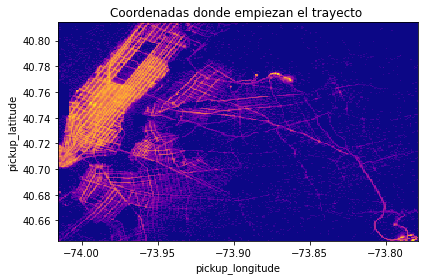

In [ ]:
plt.title('Coordenadas donde empiezan el trayecto ')
df_original.plot(df_original.pickup_longitude, df_original.pickup_latitude, colormap='plasma', f='log1p',  shape=256, colorbar=False , limits='99%')
plt.tight_layout()
plt.show()

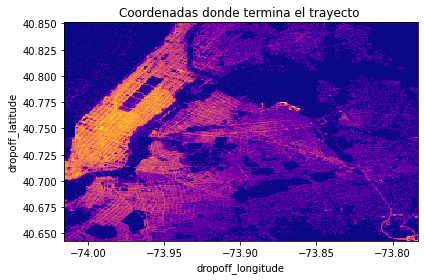

In [ ]:
plt.title('Coordenadas donde termina el trayecto ')
df_original.plot(df_original.dropoff_longitude, df_original.dropoff_latitude, colormap='plasma', f='log1p', shape=256, colorbar=False, limits='99%')
plt.tight_layout()
plt.show()